# WDBC Data Sets Analysis

The following jupyter notebook provides summary of the analysis undertaken on the `WDBC` data set.

## Outline

* **Download** section covers initial file sourcing and import
* **Descriptive analysis** section focus on answering first two question concerned with descriptive statistics of `perimeter` feature and distribution characteristics of the `radius` variable
* **Modelling** section covers last element of assignment pertaining to classifier training and model development

## Download

Download available files.
 1. List available files from the website
 2. Create absolute url paths and download files to temp folder
*The snippet useful if re-running the netbook and saves hassle with sourcing raw data*

In [30]:
# Modules
# File download and storage
import os
import sys
import tempfile
from urllib.request import urlopen
from urllib.request import urlretrieve
from urllib.parse import urljoin
from bs4 import BeautifulSoup
# Data manipulation and modelling
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import scipy.stats as stats
# Gadgets
from termcolor import colored # Coloured console output
import humanize # Human readable units (useful for file sizes, etc.)
from IPython.display import display, HTML # Common aproach to keep nice layout and avoid printing index
import seaborn as sns # Charts

In [4]:
# Download relevant files to temp storage
tmp_fld = tempfile.mkdtemp(suffix='wdbc_data', prefix='tmp')
url_dta_fld = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/'
site = urlopen(url_dta_fld)
content = site.read()
soup = BeautifulSoup(content, "html.parser")
list_urls = soup.find_all('a')
# Download desired files
dta_fls = []
for url in list_urls:
    asst_url = urljoin(url_dta_fld,url['href'])
    # Names are useful for the attribute information
    if asst_url.endswith(('.data', '.names')):
        dta_fls.append(os.path.join(tmp_fld, asst_url.split('/')[-1]))
        print(asst_url)
        urlretrieve(url=asst_url, filename=dta_fls[-1])
        print(colored('Saved: ' + dta_fls[-1], 'green'))

https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data
Saved: /var/folders/7x/kwc1y_l96t55_rwlv35mg8xh0000gn/T/tmpulsuaudvwdbc_data/breast-cancer-wisconsin.data
https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.names
Saved: /var/folders/7x/kwc1y_l96t55_rwlv35mg8xh0000gn/T/tmpulsuaudvwdbc_data/breast-cancer-wisconsin.names
https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data
Saved: /var/folders/7x/kwc1y_l96t55_rwlv35mg8xh0000gn/T/tmpulsuaudvwdbc_data/wdbc.data
https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.names
Saved: /var/folders/7x/kwc1y_l96t55_rwlv35mg8xh0000gn/T/tmpulsuaudvwdbc_data/wdbc.names
https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wpbc.data
Saved: /var/folders/7x/kwc1y_l96t55_rwlv35mg8xh0000gn/T/tmpulsuaudvwdbc_data/wpbc.data
https://archive.ics.uci.e

### Available files
_Includes summary of .names files_

In [5]:
dta_fls_info = pd.DataFrame(
    {'file' : list(map(os.path.basename, dta_fls)),
     'size' : [humanize.naturalsize(os.path.getsize(fle)) for fle in dta_fls],
     'lines' : list(map(lambda fle: sum(1 for _ in fle), dta_fls))
    })
display(HTML(dta_fls_info.to_html(index=False)))

file,lines,size
breast-cancer-wisconsin.data,98,19.9 kB
breast-cancer-wisconsin.names,99,5.7 kB
wdbc.data,79,124.1 kB
wdbc.names,80,4.7 kB
wpbc.data,79,44.2 kB
wpbc.names,80,5.7 kB


### Import

In [6]:
# --- Do not run ---
stdout_nms = []
for fle in dta_fls:
    if fle.endswith('names'):
        stdout_nms.append(os.popen("cat " + fle).read())
# --- Do not run ---
# stdout_nms
# The one coule analyse *.names files to pick relevant list but the .names file format and number of variables
# does not justify that effort.

#### Conveniance function (pd sample)
Simple conveniance function providing data frame preview by taking head/tail and wee sample in for the middle. More useful than changing defult printing options, IMHO.

In [7]:
def pd_preview (data_frame, sample_size = 3, tail_lines = 1, head_lines = 1):
    # Generate data frames to append
    df_head = data_frame.head(n = head_lines)
    df_tail = data_frame.tail(n = tail_lines)
    df_smpl = data_frame.sample(n = sample_size)
    # Append
    df_preview = df_head.append([df_smpl, df_tail])
    return df_preview

### Read

Read data sets, including **core** wdbc data set as well as other data set available in the folder (for the evenual further 

In [9]:
dta_brst_cncr = pd.read_csv(filepath_or_buffer=dta_fls[0],
                            names=['id_num', 
                                   'clump_thickness',
                                   'uniformity_cell_size',
                                   'uniformity_cell_shape',
                                   'marginal_adhesion',
                                   'single_epithelial_cell_size',
                                   'bare_nuclei',
                                   'bland_chromatin',
                                   'normal_nucleoli',
                                   'mitoses',
                                   'class'])
pd_preview(dta_brst_cncr)

,id_num,clump_thickness,uniformity_cell_size,uniformity_cell_shape,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
160,1196915,10,7,7,4,5,10,5,7,2,4
498,1204558,4,1,1,1,2,1,2,1,1,2
453,1230994,4,5,5,8,6,10,10,7,1,4
698,897471,4,8,8,5,4,5,10,4,1,4


This is **core** data set, initial analysis will be conducted on this data set.

The column names are derived as per the information available in wdbc.names. `*_lsrgst` columns reflect "worst" or largest (mean of the three largest values)" metric as per the [available documentation](https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.names).

In [10]:
# Col names
col_nms = ['ID', 'diagnosis', 'radius', 'texture', 'perimeter', 'area',
           'smoothness', 'compactness', 'concavity', 'concave_points',
           'symmetry', 'fractal_dimension', 'radius_se', 'texture_se', 
           'perimeter_se', 'area_se', 'smoothness_se', 
           'compactness_se', 'concavity_se', 'concave_points_se', 
           'symmetry_se', 'fractal_dimension_se', 
           'radius_lrgst', 'texture_lrgst', 'perimeter_lrgst',
           'area_lrgst', 'smoothness_lrgst', 
           'compactness_lrgst', 'concavity_lrgst', 
           'concave_points_lrgst', 'symmetry_lrgst', 
           'fractal_dimension_lrgst']


In [11]:
dta_wdbc = pd.read_csv(filepath_or_buffer=dta_fls[2],
                      names=col_nms)
# US ID as index
dta_wdbc.set_index(['ID'], inplace=True)

In [13]:
pd_preview(dta_wdbc)

,diagnosis,radius,texture,perimeter,area,smoothness,compactness,concavity,concave_points,symmetry,...,radius_lrgst,texture_lrgst,perimeter_lrgst,area_lrgst,smoothness_lrgst,compactness_lrgst,concavity_lrgst,concave_points_lrgst,symmetry_lrgst,fractal_dimension_lrgst
ID,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.26540,0.4601,0.11890
844359,M,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,...,22.880,27.66,153.20,1606.0,0.14420,0.25760,0.3784,0.19320,0.3063,0.08368
89813,B,14.42,16.54,94.15,641.2,0.09751,0.11390,0.08007,0.04223,0.1912,...,16.670,21.51,111.40,862.1,0.12940,0.33710,0.3755,0.14140,0.3053,0.08764
845636,M,16.02,23.24,102.70,797.8,0.08206,0.06669,0.03299,0.03323,0.1528,...,19.190,33.88,123.80,1150.0,0.11810,0.15510,0.1459,0.09975,0.2948,0.08452
92751,B,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,0.1587,...,9.456,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.00000,0.2871,0.07039


# Descriptive analysis

The following section provides initial descriptive analysis as well as introduces some addittional metrics. The assigned deliverables pertain to:
1. Computing mean, median and standard deviation of `perimeter` feature
2. Normal distribution test for `radius` variable

## *Perimeter* feature - descriptive analysis

Following the provided documentation, the `perimeter` feature is represented in the data set with use of the following variables.

In [14]:
# Case insenstive search is not required but does it's good practice
print("\n".join(s for s in col_nms if 'perimeter' in s.lower()))

perimeter
perimeter_se
perimeter_lrgst


In [15]:
# Compute required statistics using pandas df.agg
dta_smry_perimeter = dta_wdbc['perimeter'].agg(['mean', 'median', 'std'])
dta_smry_perimeter

mean      91.969033
median    86.240000
std       24.298981
Name: perimeter, dtype: float64

#### Answer

In [16]:
print('The average value of the perimeter feature is ' + str(round(dta_smry_perimeter['mean'], 2)) + 
      ', median ' + str(round(dta_smry_perimeter['median'], 2)) + ' and standard deviation is ' +
     str(round(dta_smry_perimeter['std'], 2)) + '.')

The average value of the perimeter feature is 91.97, median 86.24 and standard deviation is 24.3.


##### Box Plot

*The desired dispersion can be convenintely visualised with use of a box plot, the figure below addittionaly overplots*

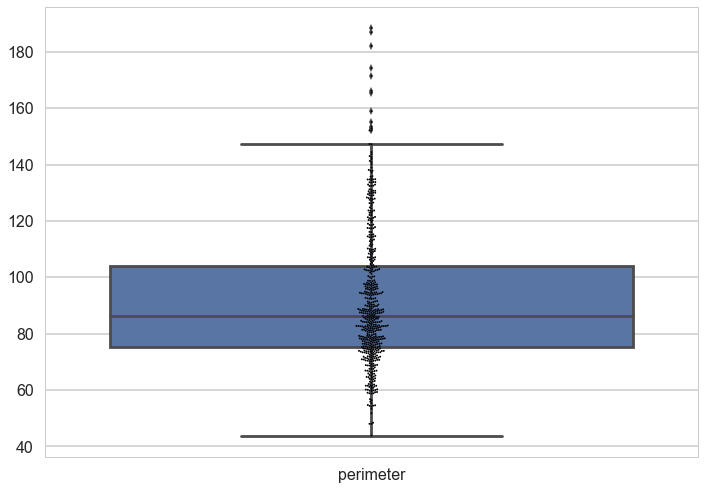

In [17]:
# Force bigger seaborn figure size: https://stackoverflow.com/a/47955814/1655567
sns.set(context='poster', style='whitegrid', rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(data=dta_wdbc[['perimeter']])
sns.swarmplot(data=dta_wdbc[['perimeter']], size=1, edgecolor="black", linewidth=.9)
# Pass added to hide matplotlib comment
pass

## Radius variable analysis

`stats.normaltest` returns chi-squared statistic and the corresponding p value.

In [18]:
k2, p = stats.normaltest(dta_wdbc[['radius']])
if p < 1e-3:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")

The null hypothesis can be rejected


With the *p < 0.01* it is unlikely that the data would come from normal distribution. This can be addittionally visulaised in figure below.

/Users/huski/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


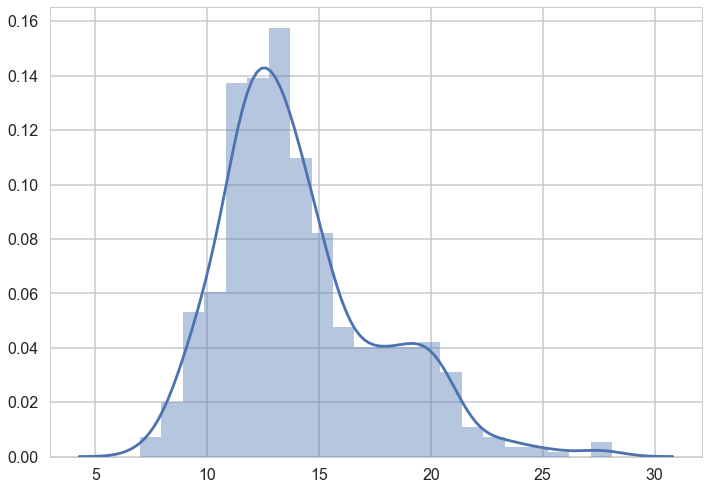

In [19]:
sns.distplot(dta_wdbc[['radius']]);

# Modelling

## Pre-processing

### Missing value check

Give the documentation, there is no need to run the missing value check. For a simple check the one could use `pandas_data_frame.isnull().any().any()`.

### Standarization

As shown in the box plot below, variables scales suggest pre-processing of the data.

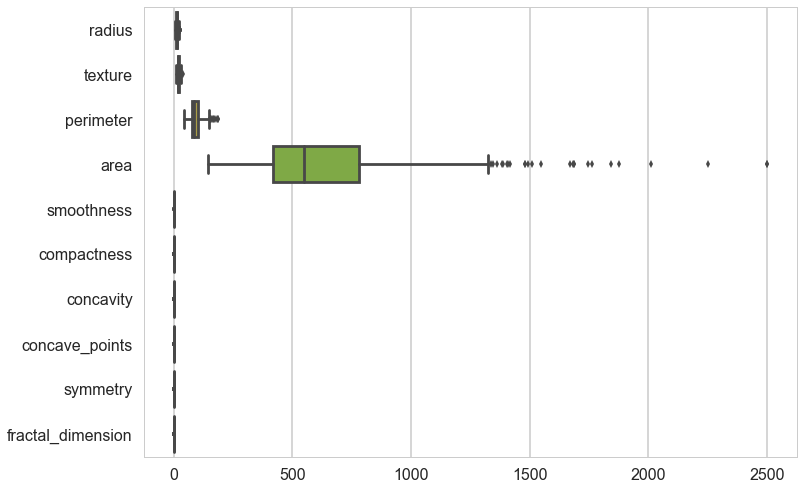

In [20]:
sns.set(context='poster', style='whitegrid', rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(data=dta_wdbc[col_nms[2:12]], orient='h')

After standarisation:

In [21]:
min_max_scaler = MinMaxScaler()
# Apply min/max scaler on wdbc data
dta_wdbc_scld = dta_wdbc
dta_wdbc_scld[col_nms[2:32]] = min_max_scaler.fit_transform(dta_wdbc[col_nms[2:32]])

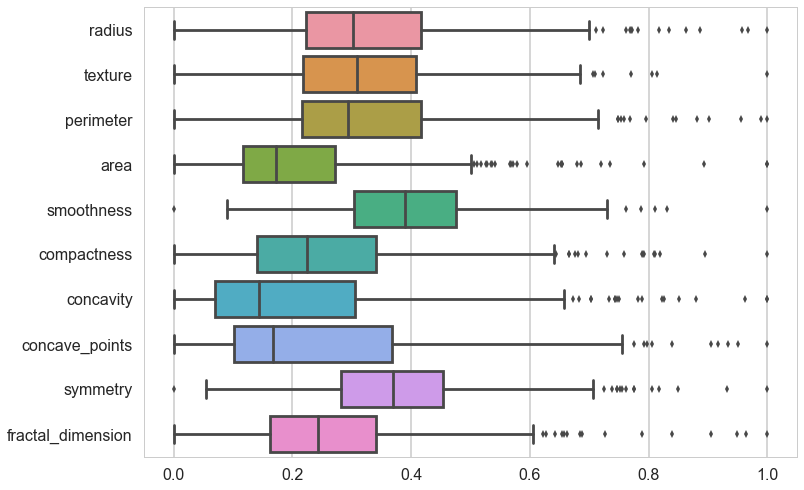

In [22]:
sns.set(context='poster', style='whitegrid', rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(data=dta_wdbc_scld[col_nms[2:12]], orient='h')

### Correlational analysis

Initial correlational analysis outlining potential dependencies across the available variables. Considering that variables were most likely collected on interval scales as read of scientific instruments and are now scaled Person correlation appaers to be the most suitable choice.

In [23]:
# Generate correlations matrix for the wdbc data
corr_wdbc_pearson = dta_wdbc_scld.corr(method = 'pearson')
# Replace diagonal values with NaNs as there is no point in plotting r = 1 relationships
np.fill_diagonal(corr_wdbc_pearson.values, np.nan)

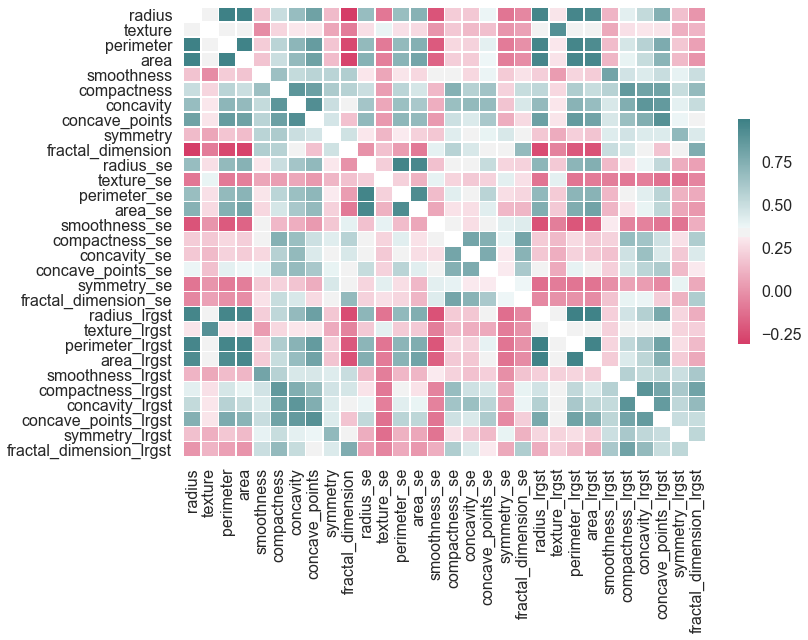

In [24]:
# Colours, aim for green high and red low
htmp_clrs = sns.diverging_palette(1, 200, as_cmap=True)
# Heatmap for each variable combinations
sns.heatmap(corr_wdbc_pearson,  
            cmap=htmp_clrs,
            square=False, 
            xticklabels=True, 
            yticklabels=True,
            linewidths=.5, 
            # Shrink colour guide
            cbar_kws={"shrink": .5})

### Class imblance

Broadly speaking, class imbalance occurs when a *class* populates less than 20% of the data set.

In [25]:
dta_wdbc_scld['diagnosis'].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

*Class imbalance problem does not occur.*

### Train/Test data set

Obtain train and test data sets.

In [32]:
# rnd_TF = np.random.rand(len(dta_wdbc_scld)) < 0.8 # Will create pseudo random T/F selection
# train = dta_wdbc_scld[rnd_TF]
# test = dta_wdbc_scld[~rnd_TF]
# sklearn approach
train, test = train_test_split(dta_wdbc_scld, test_size=0.2)

#### Preview

In [37]:
train.shape
# train.describe()

(455, 31)

In [38]:
test.shape
# test.describe()

(114, 31)

## Classifier fitting

Following [sklearn documentation](http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html), `Linear SVC` classifier is used as one of the classifiers, the reasons being:
* Assignment is concerned with category prediction
* Data is labelled
* Size is less <100K

### Linear SVC